# Imports

In [23]:
import arviz as az
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
from sympy import symbols, exp, diff, solve

# Data Extraction

In [18]:
csv_data = np.loadtxt('problem3.csv', delimiter=',', skiprows=1)
X = csv_data[:, 0]
Y = csv_data[:, 1]

# Optimization: Minimize Defects

In [19]:
# Define the symbols
beta0, beta1, beta2, x = symbols("beta0 beta1 beta2 x", real=True)

# Define the lambda function
lambda_x = exp(beta0 + beta1 * x + beta2 * x**2)

# Take the derivative with respect to x
derivative = diff(lambda_x, x)

# Solve the derivative equation for x
solution = solve(derivative, x)

print(solution)

[-beta1/(2*beta2)]


# Model

In [20]:
with pm.Model() as model:
    # Data
    x_data = pm.Data("x_data", X)
    y_data = pm.Data("y_data", Y)

    # Priors
    beta0 = pm.Normal('beta0', mu=0, sigma=100)
    beta1 = pm.Normal('beta1', mu=0, sigma=100)
    beta2 = pm.Normal('beta2', mu=0, sigma=100)

    # Mean of the Poisson distribution: λ(x)
    lambda_x = pm.math.exp(beta0 + (beta1 * x_data) + (beta2 * x_data ** 2))

    # Formula for mimizing defects: comes from the optimization above
    pm.Deterministic("conc_min", - beta1 / (2*beta2))

    # Poisson likelihood
    y = pm.Poisson('y', mu=lambda_x, observed=y_data)

    # Posterior Sampling
    trace = pm.sample(11000, tune=1000, target_accept=0.95, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta2, beta1, beta0]


/Users/adamcuculich/georgia-tech/bayesian-stats/env/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/adamcuculich/georgia-tech/bayesian-stats/env/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/adamcuculich/georgia-tech/bayesian-stats/env/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/adamcuculich/georgia-tech/bayesian-stats/env/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 15 seconds.
The number of effective samples is smaller than 25% for some parameters.


# Show Statistics

In [21]:
az.summary(trace, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,1.319,0.129,1.067,1.571,0.001,0.001,11138.0,13152.0,1.0
beta1,-4.151,0.712,-5.534,-2.758,0.007,0.005,9529.0,10483.0,1.0
beta2,3.141,0.738,1.702,4.583,0.007,0.005,10011.0,11826.0,1.0
conc_min,0.675,0.079,0.568,0.814,0.001,0.000,15740.0,17300.0,1.0


# Visual

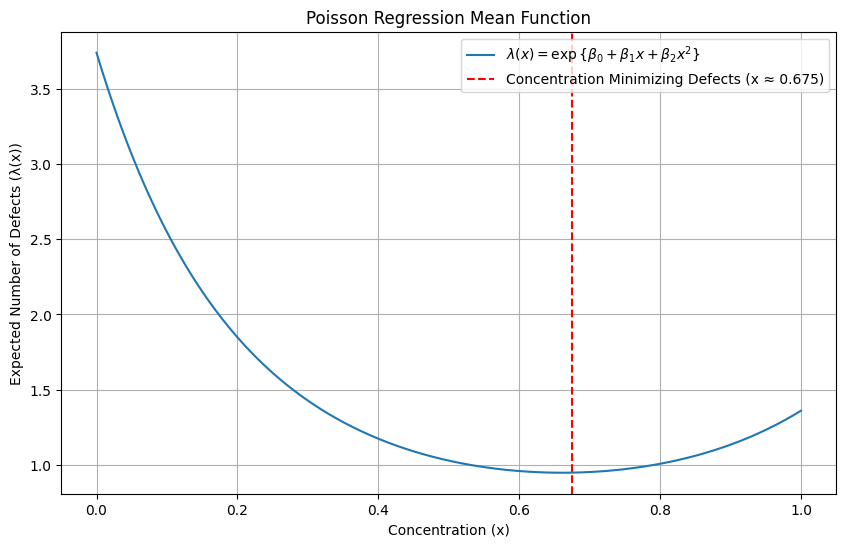

In [25]:
posterior_mean_beta0 = np.mean(trace.posterior.beta0.values)
posterior_mean_beta1 = np.mean(trace.posterior.beta1.values)
posterior_mean_beta2 = np.mean(trace.posterior.beta2.values)
posterior_mean_conc_min = np.mean(trace.posterior.conc_min.values)

def lambda_x(x):
    return np.exp(posterior_mean_beta0 + posterior_mean_beta1 * x + posterior_mean_beta2 * x**2)

# Generate a range of x values within the 0 to 1 bounds
x_values = np.linspace(0, 1, 400)
y_values = lambda_x(x_values)

# Plot the function
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, label=r'$\lambda(x) = \exp\{\beta_0 + \beta_1 x + \beta_2 x^2\}$')
plt.axvline(x=posterior_mean_conc_min, color='r', linestyle='--', label='Concentration Minimizing Defects (x ≈ {:.3f})'.format(posterior_mean_conc_min))
plt.xlabel('Concentration (x)')
plt.ylabel('Expected Number of Defects (λ(x))')
plt.title('Poisson Regression Mean Function')
plt.legend()
plt.grid(True)
plt.show()

# Comments

The above graph illustrates that the obtained defect-minimizing concentration is indeed a minimum (and not a maximum).